# Introduction to Climate Networks

In this tutorial we explain the basic conecpt of climate networks. 
This is done in for consecutive steps:  
1. Load data and preprocess 
2. Pairwise-Intercomparison between all time series
3. Generate Adjacency
4. Generate Network and analyze it   

Below the scetch visualizes it  

  
<img src="img/climate_network.png" width="500">

In [1]:
# import required packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import plot_utils as put
import scipy.stats as st
import networkx as nx  # For network analysis
import networkit as nk  # For community detection
from importlib import reload

## Data loading

### Getting familiar with the data

Many atmospheric phenomena are driven by the ocean-atmosphere interactions, since both are together responsible for the transfer of heat on our planet. Surface air temperatures (SST) fields can help us predict and understand many of this coupled atmosphere-ocean processes. For example, anomalies in the Pacific SST can lead to large climatic changes world wide. 

The monthly 2m-air temperature data from 1979-2021 are taken from [Copernicus ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview). The data are regridded on a $2.5^\circ \times 2.5^\circ$ resolution.

We use xarray to read the .nc files:

In [2]:
# Load the data to an xarray dataset
ds = xr.open_dataset('./data/era5_t2m_2.5_monmean_ds.nc')
# Just executing the dataset will give you a first overview over the dataset
ds

<xarray.Dataset>
Dimensions:  (time: 492, lat: 73, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 174.7 177.2 179.8
Data variables:
    t2m      (time, lat, lon) float32 ...

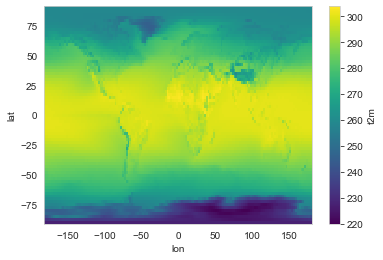

In [3]:
# Get a first impression of the data. Are they meaningful?
var_name = 't2m'  # This is the name of the climate variable = 2 meter air temperature
ds[var_name].mean(dim='time').plot()

For nicer plots we can use cartopy. This however also requires many more lines of codes which you can find in the plot_utils.py.

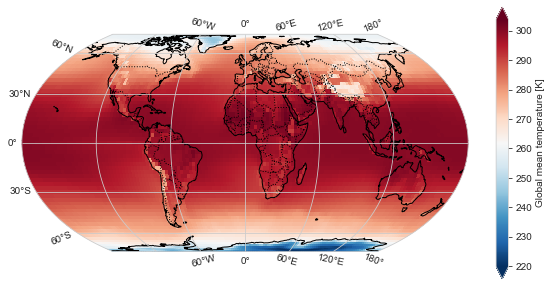

In [4]:
reload(put)
mean_t2m = ds[var_name].mean(dim='time')
im = put.plot_map(mean_t2m, label='Global mean temperature [K]', 
                  projection='EqualEarth')

## Preprocess Data
So far we have the raw data. Before we can however start with analysing the data more in detail we have to account for a few pitfalls.

### Detrend data and create anomaly time series
Plot the average global mean temperature.

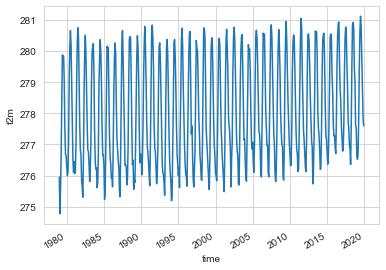

In [5]:
# Plot the average yearly temperature
# What might be the problem?
ds[var_name].mean(dim='lon').mean('lat').plot()

In the data we want to avoid correlations that arise due **to the seasonal cycle**. Therefore we compute anomaly time series in each cell:
* The anomaly of a variable is its variation relative to the **climatological mean**.  
* Climatological means can be based on the day of the year, month, season, year etc ...  
* The mean is the long-term average of the same variable. We use it as a baseline value.   
* The anomaly values are therefore the **data - climatology** 

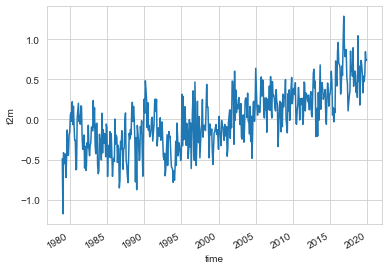

In [6]:
# Compute anomaly time series 
# Group each time point by its corresponding day of the year
group = 'dayofyear'
climatology = (
            ds[var_name].groupby(f"time.{group}").mean(dim="time")
        )
# Compute the anomalies
anomalies = ds[var_name].groupby(f"time.{group}") - climatology
anomalies.mean(dim='lon').mean('lat').plot()

In the above plot we see **a constant increase** over the last 40 years due to global warming! 
We therefore need to detrend the data.  
We do this by computing in each cell the trend and substract it then from the original dataset.  
The resulting dataset is then plotted.

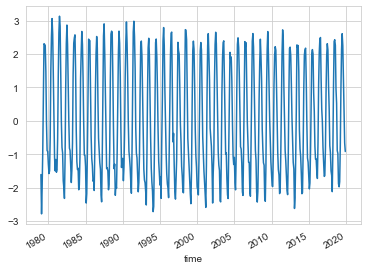

In [7]:
# Compute the fit coefficients
p = ds[var_name].polyfit(dim='time', deg=1)
# Apply the fit
fit = xr.polyval(ds['time'], p.polyfit_coefficients)
# The fit gives us the linear increase in each cell
da_detrend = ds[var_name] - fit  # Substract the linear increase from the actual data
da_detrend.mean(dim='lon').mean('lat').plot()


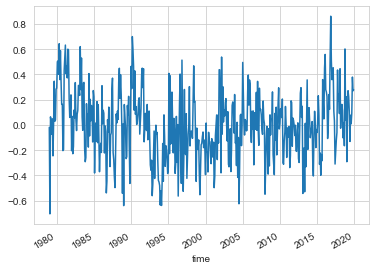

In [8]:
# Now compute anomaly time series 
group = 'dayofyear'
climatology = (
            da_detrend.groupby(f"time.{group}").mean(dim="time")
        )
anomalies = da_detrend.groupby(f"time.{group}") - climatology
anomalies.mean(dim='lon').mean('lat').plot()
ds['anomalies'] = anomalies


## 2. Compute the adjacency matrix
Now we are ready to start analyzing the data. We use the scipy library which is very similar to numpy. In order to use our SST anomaly data as inputs to neural networks (NN) we have however still have to preprocess the data. The following preprocessing steps are usually required: 

1. **Remove missing data**: Some datasets contain missing data. We set this data to zero (=the climatology)

2. **Reshape**: So far the data is in the shape (time, lon, lat). In order to being ready to be used it has to be a 2-dimensional array containing all time series as rows.

In [9]:
da = ds['anomalies']  # Use the anomaly data to compute the pairwise correlations
print('Dataset shape: ', da.shape)
dim_time, dim_lat, dim_lon = da.shape
# Bring all into a form of an array of time series
data = []
data = []
for idx, t in enumerate(da.time):
        buff = da.sel(time=t.data).data.flatten()  # flatten each time step
        buff[np.isnan(buff)] = 0.0  # set missing data to climatology
        data.append(buff)
data = np.array(data)
print('Flattend Dataset shape: ', data.shape)


Dataset shape:  (492, 73, 144)
Flattend Dataset shape:  (492, 10512)


Now we can apply the Spearman's correlation function.  

<img src="img/Spearman.png" width="300"> [Ref](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient#/media/File:Spearman_fig1.svg)

In [10]:
corr, pvalue =  st.spearmanr(
        data, axis=0, nan_policy='propagate')
print('Shape of correlation Matrix: ', corr.shape)


Shape of correlation Matrix:  (10512, 10512)


Not all correlations are statistically significant.
Let's first exclude non-significant correlations

In [11]:
confidence = 0.999
mask_confidence = np.where(pvalue <= (1 - confidence), 1, 0)  # p-value test
corr = np.where(mask_confidence==1, corr, 0)

In [12]:
# get minimum value that is still accounted as a correlation
# Do you think this is fine?
np.nanmin(np.where(np.abs(corr) != 0, np.abs(corr), np.nan))

0.14790797759462537

Now finally compute the adjacency matrix of the network
TODO provide formula

In [13]:
threshold = 0.4  # absolute threshold for correlations
mask_correlation = np.where(np.abs(corr) >= threshold, 1, 0)

# A link in the adjacency is placed for all significant values above the threshold
adjacency = mask_confidence * mask_correlation

# Obtain density of adjacency matrix.
density = (
    np.count_nonzero(adjacency.flatten()) / adjacency.shape[0]**2
)
print("density of adjacency: ", density)

density of adjacency:  0.022751341367638983


We can now plot the Adjacency $A$ of the network. 
Can you try to explain the patterns you see?

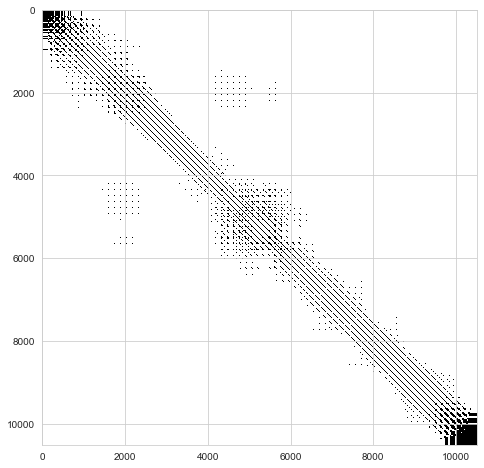

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(X=adjacency, cmap='Greys',  interpolation='nearest')


## 3. Analzye the network

To more easily analyze the network we use the [networkx package](https://networkx.org/), using that we have the adjacency.
Networkx provides powerful functions to further analyse the graph's topology.

In [15]:
# Use networkx for better using dealing with the adjacency matrix
import networkx as nx
cnx = nx.DiGraph(adjacency)

# Set the longitude and latitude as node attributes
lons = ds.lon
lats = ds.lat
lon_mesh, lat_mesh = np.meshgrid(lons, lats)  # This gives us a list of longitudes and latitudes per node
nx.set_node_attributes(cnx, {node: lon_mesh.flatten()[node] for node in cnx.nodes()}, 'lon')
nx.set_node_attributes(cnx, {node: lat_mesh.flatten()[node] for node in cnx.nodes()}, 'lat')


### Node degree

A first very commonly used step is to look at the node degree. It can give a you a first very informative impression of the network.   
The node degree of a node $i$ of the network is computed using the Adjacency matrix $A$:    
$$ k_i = \sum_i A_{ij} $$ 

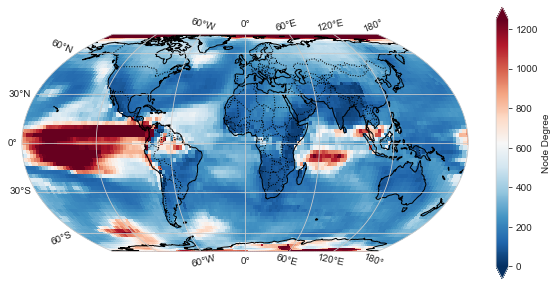

In [16]:
# Compute the node degree and plot it
reload(put)
degrees = np.array(cnx.degree())[:,1] # This returns the list of degrees
# Plot degrees
degree_arr = np.array(cnx.degree())[:,1].reshape(dim_lat, dim_lon)
degree_map = put.create_map_for_da(da=ds[var_name], data=degree_arr, name='degree')
im = put.plot_map(degree_map, 
                  label='Node Degree', 
                  projection='EqualEarth',
                  vmin=0,
                  vmax=1250)

### Global Oscillation Modes

The largest interanual variability of the climate is characterized by SST anomalies in the tropical Pacific, called the **El Nino Southern Oscillation (ENSO)**. ENSO has a normal, warm phase called **El Nino** and a cold phase called **La Nina** with different impacts on global climate. 

The **Indian Ocean Dipole (IOD)**, also known as the Indian Nino, is an irregular oscillation of sea surface temperatures in which the western Indian Ocean becomes alternately warmer (positive phase) and then colder (negative phase) than the eastern part of the ocean. It is known to be strongly correlated to the ENSO. 


### Visualize single edges of the network
To better analyze single parts of the network we want to extract the links from a specific region.  
As an example we now look at the red spot in the Indian Occean Dipole and try to visualize where the links of this region go to.

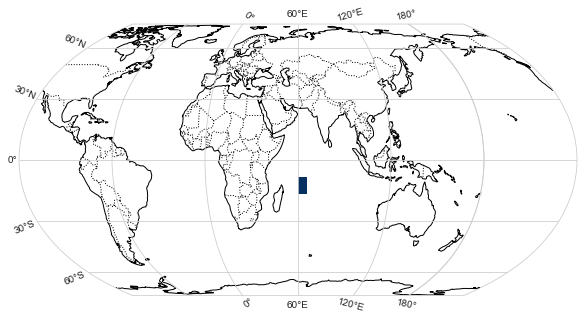

In [17]:
# Find out the nodes of the source region
lat_range = [-10, -15]
lon_range = [60,65]
# Why is this masked needed?
mask = (
        (degree_map['lat'] >= min(lat_range))
        & (degree_map['lat'] <= max(lat_range))
        & (degree_map['lon'] >= min(lon_range))
        & (degree_map['lon'] <= max(lon_range))
        )
source_map = xr.where(mask, 1, np.nan)
im = put.plot_map(source_map, 
                  bar=False, 
                  projection='EqualEarth',
                  central_longitude=60)

# Get Ids of locations
source_ids = np.where(source_map.data.flatten()==1)[0]  # flatten data and get position in array

# Find target Ids in the network
edge_list = []
for sid in source_ids:
        edge_list.append(list(cnx.edges(sid)))

edge_list = np.concatenate(edge_list, axis=0)  # transform to 2d np array

The plotting of edges is rather complicated. Therefore we use again an own defined plotting 
function

{'ax': <GeoAxesSubplot:>, 'projection': 'PlateCarree'}

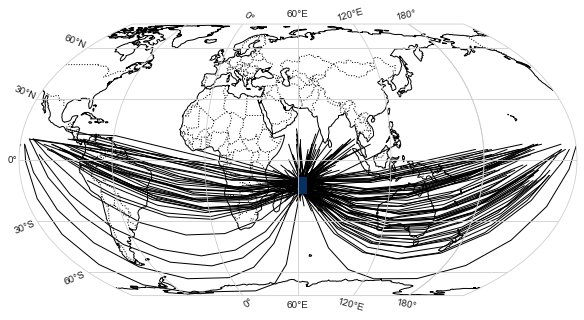

In [18]:
reload(put)
# Plot edges from this source region
im = put.plot_map(source_map, 
                  bar=False, 
                  projection='EqualEarth',
                  central_longitude=60)
put.plot_edges(cnx=cnx,
               edges=edge_list[::10],
               ax=im['ax'])  # Plot every 10th


## 4. Community detection in climate networks
<img src="img/Network_Community_Structure.png" width="300"> [Ref](https://en.wikipedia.org/wiki/Community_structure)

Now we want to see what is the overall structure of the network.  
Therefore we want to identify communities in the network. There are many algorithms to detect communities in graphs.  
Here, we use the standard [Louvain algorithm](https://en.wikipedia.org/wiki/Louvain_method) from the [NetworKit](https://networkit.github.io/dev-docs/notebooks/Community.html) package.  
It basically optimizes local density of edges to cluster a given graph into communities. 

How Community detection works:  

<img src="img/Network_community_graph.png" width="400"> [Ref](https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0232-2)
<img src="img/communities_adjacency.png" width="400"> [Ref](https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0232-2)

In [19]:
# nk algorithm needs the nx network to be transformed as a nk object
cnk = nk.nxadapter.nx2nk(cnx.to_undirected())
# Use the Parallel Louvain Method (PLM) of NetworkIt
nkCommunities = nk.community.detectCommunities(
            cnk, algo=nk.community.PLM(cnk, True)
        )
CommunityIds = np.array(nkCommunities.getVector())

Communities detected in 0.04629 [s]
solution properties:
-------------------  -----------
# communities           8
min community size    772
max community size   1727
avg. community size  1314
modularity              0.750594
-------------------  -----------


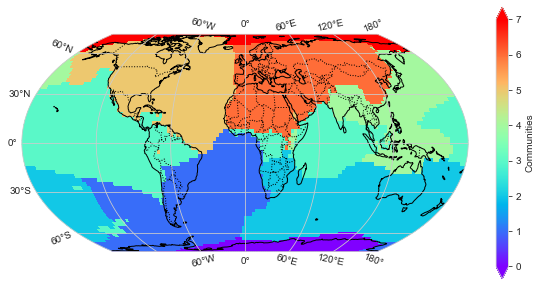

In [20]:

community_map = put.create_map_for_da(da=ds[var_name], data=CommunityIds.reshape(dim_lat, dim_lon), name='Communities')
im = put.plot_map(community_map, bar=True, 
                  cmap='rainbow',
                  projection='EqualEarth',
                  central_longitude=0)

## 5. Clustering of Climate Data
Compute the clusters of based on complete linkage clustering of the Spearman's Correlation Matrix!  
In order to group time series by similarity we use the standard fast greedy hierarchical agglomerative complete linkage clustering].  
This clustering is performed  in a metric space with dissimilarities between time series as distances.  


We follow the method from [Rheinwalt et al. 2015](https://link.springer.com/chapter/10.1007/978-3-319-17220-0_3).
The distance function is here the cosine of the correlation:  
$$ \rho_{X,Y} = \cos (\theta_{X,Y}) $$
where the angle can have values $\theta_{X,Y} = 0,\dots, 2\pi$.  
This ensures that as more similar two time series $X,Y$ are the smaller their distance is!
We use complete linkage implementation from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

Having computed the distances we can proceed computing the dendrogram:  

<img src="img/example_dendrogram.png" width="600"> [Ref](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)


In [21]:
def get_distance(corr, pvalue, confidence=0.999, threshold=None):
    """Get correlation and distance threshold for a given confidence level.

    Note: only positive correlations are considered here

    Return:
    -----
    threshold: float
        Threshold where the clustering is stopped
    distance: np.ndarray (n, n)
        Distance matrix
    corr_pos: np.ndarray (n, n)
        Correlation matrix with only positive correlations
    """
    # get only absolute correlations
    corr_pos = np.abs(corr)

    # get distance matrix
    distance = np.arccos(corr_pos)

    # consider only correlations with corresponding pvalues smaller than (1-confidence)
    mask_confidence = np.where(pvalue <= (
        1 - confidence), 1, 0)  # p-value test
    corr_pos = np.where(mask_confidence == 1, corr_pos, np.nan)

    # get threshold
    if threshold is None:
        idx_min = np.unravel_index(
                np.nanargmin(corr_pos.data), np.shape(corr_pos.data)
            )
    else:
        mask_corr = np.where(corr_pos >= threshold, 
                             corr_pos, np.nan)
        idx_min = np.unravel_index(
                np.nanargmin(mask_corr.data), np.shape(corr_pos.data)
            )
    threshold_corr = corr_pos[idx_min]
    threshold_dist = distance[idx_min]
    
    print(f"p-value {pvalue[idx_min]}, \n",
          f"correlation {threshold_corr} \n",
          f"Min distance threshold {threshold_dist}")

    return distance, threshold_dist

def complete_linkage_cluster(distance, threshold=None, linkage="complete", n_clusters=None):
        """Complete linkage clustering.
        Return:
        -------
        labels: list (n)
            Cluster label of each datapoint
        model: sklearn.cluster.AgglomerativeClustering
            Complete linkage clustering model
        """
        # Use Scipy Agglomerative Clustering for distances clustering!
        from sklearn.cluster import AgglomerativeClustering
        compute_full_tree=True,
        if n_clusters is not None:
            # Exactly one of n_clusters and distance_threshold has to be set,
            # and the other needs to be None. Here we set n_clusters if given!
            threshold = None
            compute_full_tree = False
        
        # create hierarchical cluster
        model = AgglomerativeClustering(
            distance_threshold=threshold, 
            n_clusters=n_clusters, 
            compute_full_tree=compute_full_tree,
            compute_distances=True,
            affinity='precomputed', 
            connectivity=None, 
            linkage=linkage
        )
        labels = model.fit_predict(distance)
        print(
            f"Found {np.max(labels)+1} clusters for the given threshold {threshold}.")
        return labels, model


In [22]:
da = ds['anomalies']  # Use the anomaly data to compute the pairwise correlations
print('Dataset shape: ', da.shape)
dim_time, dim_lat, dim_lon = da.shape
# Bring all into a form of an array of time series
data = []
data = []
for idx, t in enumerate(da.time):
        buff = da.sel(time=t.data).data.flatten()  # flatten each time step
        buff[np.isnan(buff)] = 0.0  # set missing data to climatology
        data.append(buff)
data = np.array(data)
print('Flattend Dataset shape: ', data.shape)
corr, pvalue =  st.spearmanr(
        data, axis=0, nan_policy='propagate')
print('Shape of correlation Matrix: ', corr.shape)


Dataset shape:  (492, 73, 144)
Flattend Dataset shape:  (492, 10512)
Shape of correlation Matrix:  (10512, 10512)


In [23]:
distance, threshold_dist = get_distance(corr=corr, pvalue=pvalue, threshold=0.4)
clusterIds, model = complete_linkage_cluster(distance=distance, 
                                             threshold=threshold_dist,
                                             n_clusters=9)

p-value 2.5028767123945676e-20, 
 correlation 0.40000028212772265 
 Min distance threshold 1.1592791729008058
Found 9 clusters for the given threshold None.


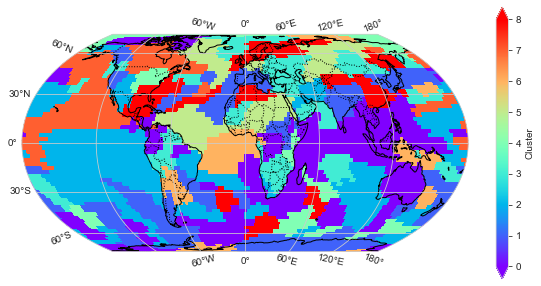

In [24]:
reload(put)
cluster_map = put.create_map_for_da(da=ds[var_name], data=clusterIds.reshape(dim_lat, dim_lon), name='Cluster')
im = put.plot_map(cluster_map, bar=True, 
                  cmap='rainbow',
                  projection='EqualEarth',
                  central_longitude=0)

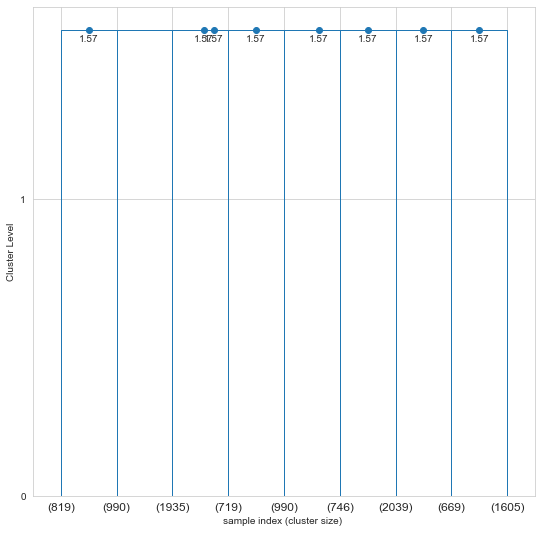

In [44]:
reload(put)
_ = put.fancy_dendrogram(model=model, 
                     truncate_mode="lastp",
                     p=9
                     )